# Task 1: Model Fitting and Testing
***

We split our dataframe into train and test sets, and then fit the model (svm - linear kernel) and run predictions.

In [2]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.util import ngrams

from sklearn.externals import joblib

from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [131]:
df = pd.read_csv('dataframe_pickles/o_codes_extended_1000.csv', encoding='utf-8-sig', low_memory=False)
df.drop('Unnamed: 0', axis=1, inplace=True)

X = df['3'].values   #inputs - abstract
y = df['5'].values   #outputs - 1: F    0: ~F

X_train, X_test, y_train, y_test = train_test_split(X,y)

>We can create our own features to fit to the model.

In [132]:
#keywords associated with 'F' JEL codes
kw = []
max_length = 1
for line in open('o_code_keyword.txt'):
    words = line.split(',')
    for phrase in words:
        phrase = phrase.split()
        list_of_words = []
        for word in phrase:
            list_of_words.append(re.sub(r"[^\w\-]+", '', word))
            
        if len(list_of_words) > 0:
            w = list_of_words[0].lower()
    
            if len(list_of_words) > 1:
                for i in list_of_words[1:]:
                    w = w + ' ' + i.lower()
                    
                if len(list_of_words) > max_length:
                    max_length = len(list_of_words)
                    
            
                kw.append(w) 
            else:
                kw.append(w)
        else:
            pass

kw = list(set(kw))
kw

['nic',
 'spillovers',
 'environmental',
 'democracy',
 'two gap',
 'rights',
 'factor proportions',
 'pollution and growth',
 'taxation',
 'caste',
 'technological choice',
 'import competing',
 'agrifood',
 'driven',
 'underdevelopment',
 'global studies',
 'o ring theory',
 'country size',
 'country studies',
 'government spending',
 'deregulation',
 'minorities',
 'malnutrition',
 'legal institutions',
 'innovation policy',
 'policy making',
 'nutrition',
 'technology measurement',
 'ngo',
 'wealth data',
 'growth of developing countries',
 'labor markets',
 'unbalanced growth',
 'capacity',
 'primary products',
 'skill',
 'economy',
 'copyright',
 'export led',
 'imf conditionality',
 'international',
 'income growth',
 'determinants of development',
 'neoclassical growth model',
 'legal institutions and growth',
 'financial flows',
 'debtor nation',
 'inventions',
 'taxes',
 'foreign assistance',
 'technology',
 'infrastructure',
 'labor migration',
 'innovation',
 'genocide',
 '

In [133]:
class Feature_Kw(BaseEstimator, TransformerMixin):
    def __init__(self, kw, max_len):
        self.kw = kw
        self.max_len = max_len

    def fit(self, examples, y=None):
        return self

    def transform(self, examples, y=None):
        
        X = np.zeros((len(examples), len(self.kw)))
        
        tmp = []
        first_pass = True
        while self.max_len > 0:
            for i, abstract in enumerate(examples):
                token = word_tokenize(abstract)
                tmp_grams = list(ngrams(token, self.max_len))
                grams = [' '.join(i) for i in tmp_grams]
                for k in self.kw:
                    if first_pass == True:
                        if k in grams:
                            tmp.append(1)
                        else:
                            tmp.append(0)
                            
                        self.max_len -= 1
                    else:
                        if k in grams:
                            ind = self.kw.index(k)
                            tmp[ind] = 1
                            
                        self.max_len -= 1
                            
                first_pass = False
            
            X[i, :] = np.array(tmp)
        
        return X

In [134]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)),
            ('keywords', Feature_Kw(kw, max_length))
        ])),
        ('classifier', SGDClassifier(loss='hinge', n_iter=200, penalty='elasticnet'))
    ])

In [135]:
scores = cross_val_score(pipeline, X_test, y_test, cv=5)

print("Scores: ", scores)
print("Accuracy (mean, std): ", (scores.mean(), scores.std() * 2))

Scores:  [ 0.88488488  0.87837838  0.87537538  0.87781673  0.88827655]
Accuracy (mean, std):  (0.88094638336649655, 0.0096610029798980691)


>We develop a ROC curve.

In [136]:
from sklearn.metrics import roc_curve, auc

In [137]:
y_score = pipeline.fit(X_train, y_train).decision_function(X_test)

In [138]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test, y_score, pos_label=1)
roc_auc[0] = auc(fpr[0], tpr[0])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(), pos_label=1)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

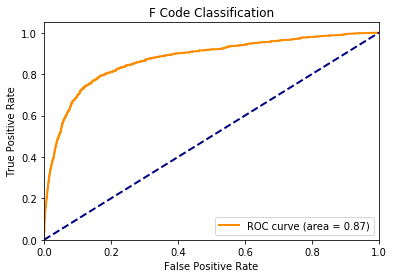

In [139]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("F Code Classification")
plt.legend(loc="lower right")
plt.show()

>Save our model for later.

In [140]:
joblib.dump(pipeline, 'pipeline_o.pkl')

['pipeline_o.pkl']